Combining the fusion.py code with the ComPat stochastic inducer
======================================================



In [1]:
%matplotlib notebook
import numpy as np
import fusion
import matplotlib.pyplot as plt
plt.ion()
import scipy.constants  
eV = scipy.constants.eV
import ComPat

**fusion.solve_Te** solves

$$\frac{3}{2}\;\frac{\partial}{\partial t}\left(n(\rho,t) T(\rho,t)\right) =
    \nabla_\rho \left[ n(\rho,t) \chi(\rho,t) \nabla_\rho
    (T(\rho,t))\right] + S(\rho, t)$$

with a boundary condition given by $Te_{bc}$ and an initial
uniform temperatore of 1000 eV; the quantities are

- $n(\rho,t)$ characterizes the plasma density

- $\chi(\rho,t)$ characterizes the thermal conductivity

- $S(\rho,t)$ characterizes the source

The geometry of the simulation is characterised by the minor radius
$a_0$, major radius $R_0$ and elongation $E_0$
(while the geometry is solved in the cylindrical approximation, the
actual radius used, $a$, is adjusted on the basis of $a_0$
and $E_0$).

Use the default case as the basis.

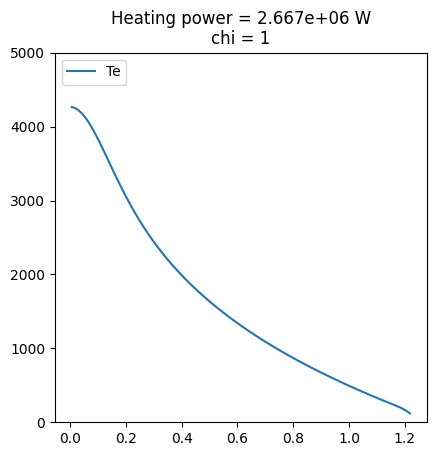

In [2]:
Te, ne, rho, rho_norm, Qe = fusion.solve_Te()

Calculate the flux by differentiation and by integration of the source.

<IPython.core.display.Javascript object>


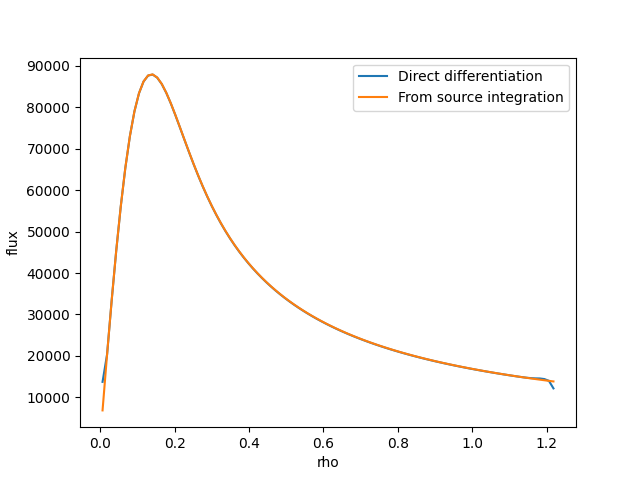

Text(0, 0.5, 'flux')

In [3]:
Gd = -np.gradient(Te, rho) * ne * eV
 
Gi = np.cumsum(Qe *  np.diff(rho).mean() * rho) / (rho + np.diff(rho).mean()/2)
Gi = np.append([Gi[0]/2],(Gi[1:]+Gi[:-1])/2)

plt.figure()
plt.plot( rho, Gd, label='Direct differentiation' )
plt.plot( rho, Gi, label='From source integration' )
plt.legend(loc=0)
plt.xlabel('rho')
plt.ylabel('flux')

Parameters for the ComPat stochastic model
- Starting flux, destination flux and overshoot level all set by the steady state flux at mid radius
- 100 points of which the first 10 are overshoot and the remaining 90 the "steady-state" phase

In [4]:
s2 = 0.2; s3 = 0.2; d2 = 10; d3 = 10
N1 = 10; N2 = 90; N3 = 30
l1 = np.log10(Gi[Gi.shape[0]//2])
l2 = l1; l3 = l1
x1 = l1; x2 = l1**2

First just calculate what the stochastic flux is, and the derived chi assuming the initial Te.

Note that each block is just a restart from the initial state.

<IPython.core.display.Javascript object>


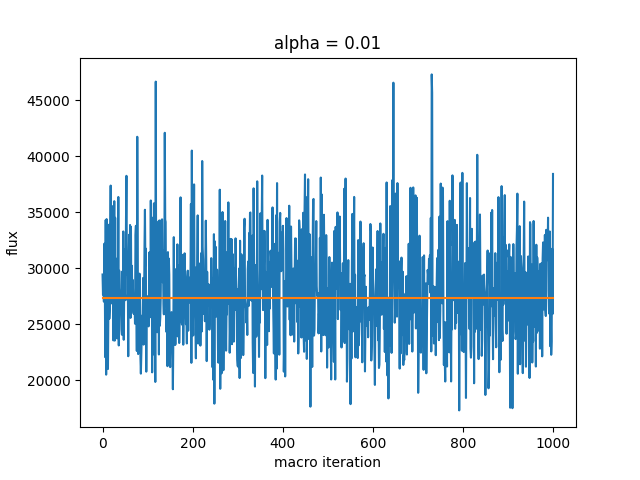

Text(0.5, 1.0, 'alpha = 0.01')

In [5]:
alpha=0.01

runs = {}
for N in  np.arange(0,1000): 
  runs[N] = {}
  runs[N]['x'], runs[N]['mean'], runs[N]['std'], runs[N]['xrange'], runs[N]['x1'], runs[N]['x2'] = ComPat.randomize(N1, N2, N3, l1, l2, l3, s2, s3, d2, d3, x1, x2, alpha)
  runs[N]['chi'] = 10 ** runs[N]['x1'] / Gd[Gd.shape[0]//2]

plt.figure()
plt.plot(10**np.array([r['x1'] for r in runs.values()]))
plt.xlabel('macro iteration')
plt.ylabel('flux')
plt.plot([0,1000], [10**x1, 10**x1])
plt.title('alpha = %s' % (alpha))

<IPython.core.display.Javascript object>


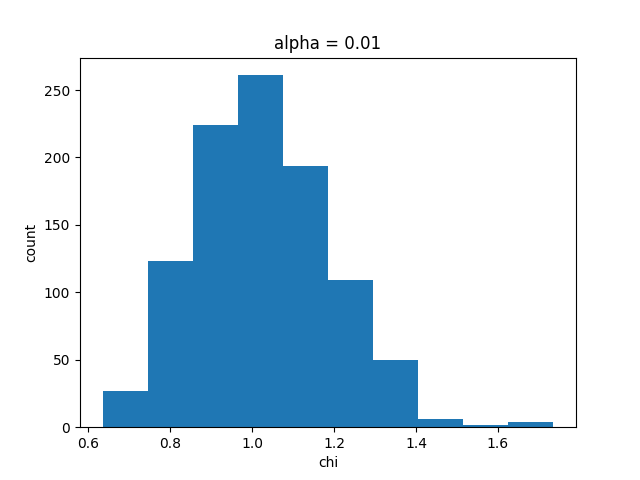

Text(0.5, 1.0, 'alpha = 0.01')

In [6]:
plt.figure()
plt.hist(np.array([r['chi'] for r in runs.values()]))
plt.xlabel('chi')
plt.ylabel('count')
plt.title('alpha = %s' % (alpha))

Now we will calculate the steady state Te profile for each of the cases

In [7]:
for N in  np.arange(0,1000): 
  print(N)
  runs[N]['Te'], runs[N]['ne'], runs[N]['rho'], runs[N]['rho_norm'], runs[N]['Qe'] = fusion.solve_Te(chi = runs[N]['chi'], plots=False)

0
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
1
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
2
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
3
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
4
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
5
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
6
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
7
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
8
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
9
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
10
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
11
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
12
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
13
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
14
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
15
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
16
Volume = 88.8264396098042 m^3
H

Heating power = 2.000e+06 W
137
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
138
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
139
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
140
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
141
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
142
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
143
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
144
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
145
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
146
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
147
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
148
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
149
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
150
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
151
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
152
Volume = 88.8264396098042 m^3
Heating 

Heating power = 2.000e+06 W
269
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
270
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
271
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
272
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
273
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
274
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
275
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
276
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
277
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
278
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
279
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
280
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
281
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
282
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
283
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
284
Volume = 88.8264396098042 m^3
Heating 

403
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
404
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
405
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
406
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
407
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
408
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
409
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
410
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
411
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
412
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
413
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
414
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
415
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
416
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
417
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
418
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
419
Volu

537
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
538
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
539
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
540
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
541
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
542
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
543
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
544
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
545
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
546
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
547
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
548
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
549
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
550
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
551
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
552
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
553
Volu

Heating power = 2.000e+06 W
672
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
673
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
674
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
675
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
676
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
677
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
678
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
679
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
680
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
681
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
682
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
683
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
684
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
685
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
686
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
687
Volume = 88.8264396098042 m^3
Heating 

806
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
807
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
808
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
809
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
810
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
811
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
812
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
813
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
814
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
815
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
816
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
817
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
818
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
819
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
820
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
821
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
822
Volu

939
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
940
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
941
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
942
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
943
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
944
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
945
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
946
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
947
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
948
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
949
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
950
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
951
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
952
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
953
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
954
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
955
Volu

Plot the temperatures for all of the cases

<IPython.core.display.Javascript object>


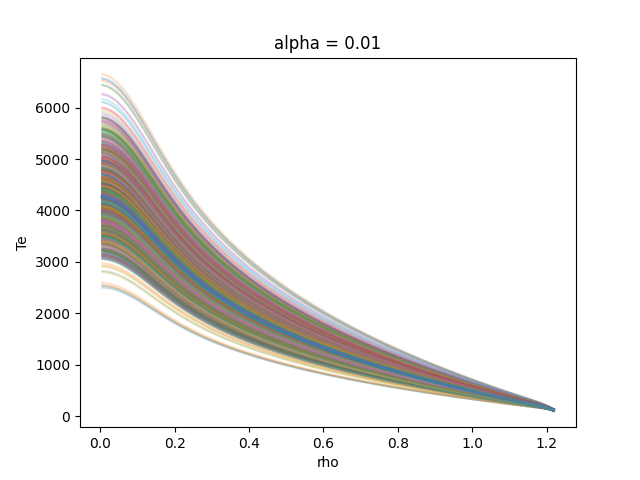

Text(0.5, 1.0, 'alpha = 0.01')

In [8]:
plt.figure()
for k, v in runs.items():
  plt.plot(v['rho'], v['Te'], label=k, alpha=0.25)
plt.plot(rho, Te, linewidth=3, alpha=0.5, label='REF')
plt.xlabel('rho')
plt.ylabel('Te')
plt.title('alpha = %s' % (alpha))

And now look at the distribution function of the core Te and chi

<IPython.core.display.Javascript object>


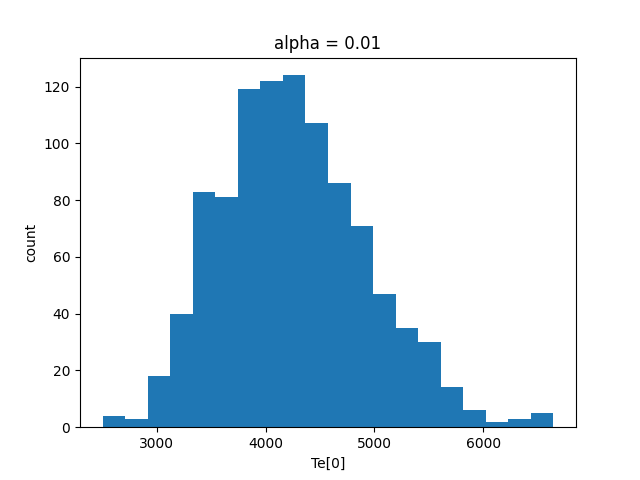

4260.341908830893 675.0906035769146


Text(0.5, 1.0, 'alpha = 0.01')

In [9]:
Te_runs = np.array([r['Te'] for r in runs.values()])
plt.figure()
plt.hist(Te_runs[:,0], bins=20)
print(np.mean(Te_runs, axis=0)[0], np.std(Te_runs, axis=0)[0])
plt.xlabel('Te[0]')
plt.ylabel('count')
plt.title('alpha = %s' % (alpha))

Now consider the approach to steady-state where the initial flux is 10% of the steady-state flux.

<IPython.core.display.Javascript object>


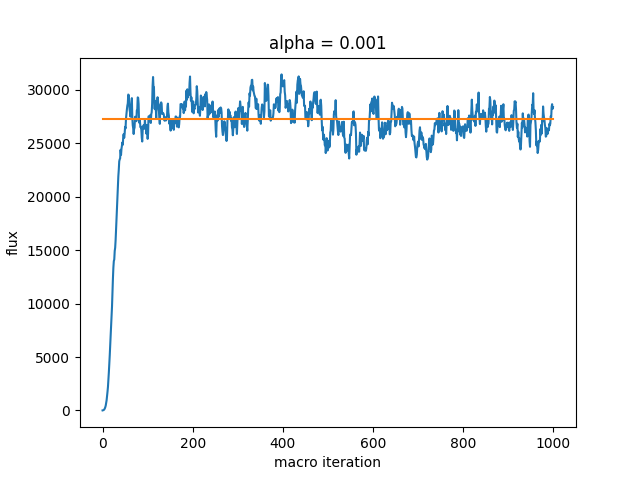

Text(0.5, 1.0, 'alpha = 0.001')

In [10]:
alpha=0.001
l1_c = x1/10
x1_c = x1/10

new_runs = {}
for N in  np.arange(0,1000): 
  new_runs[N] = {}
  new_runs[N]['x'], new_runs[N]['mean'], new_runs[N]['std'], new_runs[N]['xrange'], new_runs[N]['x1'], new_runs[N]['x2'] = ComPat.randomize(N1, N2, N3, l1=l1_c, l2=l2, l3=l3, s2=s2, s3=s3, d2=d2, d3=d3, x1=x1_c, x2=x2, alpha=alpha)
  x1_c = new_runs[N]['x1']
  l1_c = x1_c
  new_runs[N]['chi'] = 10 ** new_runs[N]['x1'] / Gd[Gd.shape[0]//2]

plt.figure()
plt.plot(10**np.array([r['x1'] for r in new_runs.values()]))
plt.xlabel('macro iteration')
plt.ylabel('flux')
plt.plot([0,1000], [10**x1, 10**x1])
plt.title('alpha = %s' % (alpha))

In [11]:
for N in  np.arange(0,1000): 
  print(N)
  new_runs[N]['Te'], new_runs[N]['ne'], new_runs[N]['rho'], new_runs[N]['rho_norm'], new_runs[N]['Qe'] = fusion.solve_Te(chi = new_runs[N]['chi'], plots=False)

0
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
1
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
2
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
3
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
4
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
5
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
6
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
7
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
8
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
9
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
10
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
11
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
12
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
13
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
14
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
15
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
16
Volume = 88.8264396098042 m^3
H

134
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
135
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
136
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
137
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
138
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
139
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
140
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
141
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
142
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
143
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
144
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
145
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
146
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
147
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
148
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
149
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
150
Volu

270
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
271
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
272
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
273
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
274
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
275
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
276
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
277
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
278
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
279
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
280
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
281
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
282
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
283
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
284
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
285
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
286
Volu

406
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
407
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
408
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
409
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
410
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
411
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
412
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
413
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
414
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
415
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
416
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
417
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
418
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
419
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
420
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
421
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
422
Volu

539
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
540
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
541
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
542
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
543
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
544
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
545
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
546
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
547
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
548
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
549
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
550
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
551
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
552
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
553
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
554
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
555
Volu

673
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
674
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
675
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
676
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
677
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
678
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
679
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
680
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
681
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
682
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
683
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
684
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
685
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
686
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
687
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
688
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
689
Volu

808
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
809
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
810
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
811
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
812
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
813
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
814
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
815
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
816
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
817
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
818
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
819
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
820
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
821
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
822
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
823
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
824
Volu

Heating power = 2.000e+06 W
941
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
942
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
943
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
944
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
945
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
946
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
947
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
948
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
949
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
950
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
951
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
952
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
953
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
954
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
955
Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W
956
Volume = 88.8264396098042 m^3
Heating 

Plot the central Te as a function of macro iteration number.

<IPython.core.display.Javascript object>


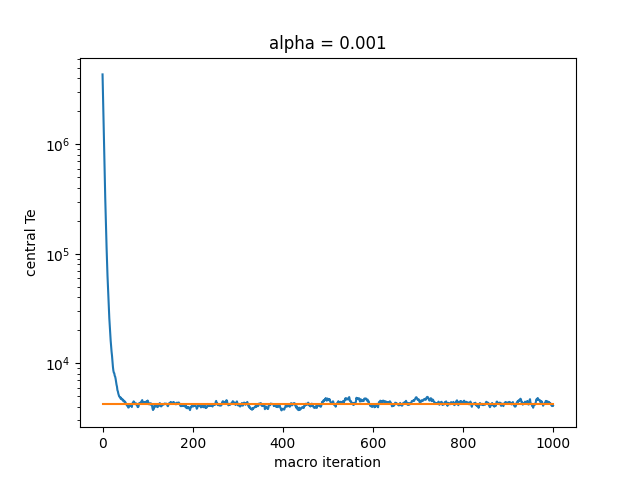

Text(0.5, 1.0, 'alpha = 0.001')

In [12]:
Te_runs = np.array([r['Te'] for r in new_runs.values()])
plt.figure()
plt.semilogy(Te_runs[:,0])
plt.xlabel('macro iteration')
plt.ylabel('central Te')
plt.plot([0,1000], [Te[0], Te[0]])
plt.title('alpha = %s' % (alpha))

And now look at the distribution of central Te

<IPython.core.display.Javascript object>


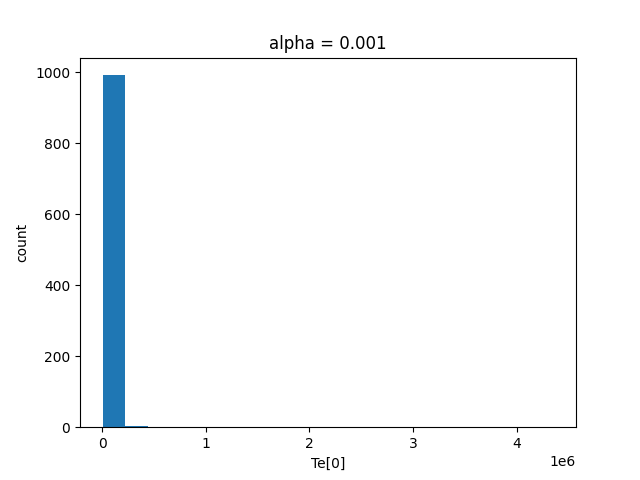

16648.23344919145 178381.77532206365


In [13]:
plt.figure()
plt.hist(Te_runs[:,0], bins=20)
plt.xlabel('Te[0]')
plt.ylabel('count')
plt.title('alpha = %s' % (alpha))
print(np.mean(Te_runs, axis=0)[0], np.std(Te_runs, axis=0)[0])

<IPython.core.display.Javascript object>


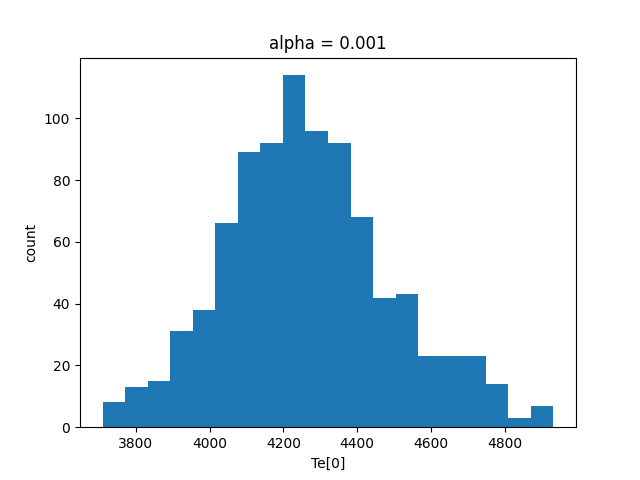

4267.996140753702 226.7943083766366


In [14]:
plt.figure()
plt.hist(Te_runs[100:,0], bins=20)
plt.xlabel('Te[0]')
plt.ylabel('count')
plt.title('alpha = %s' % (alpha))
print(np.mean(Te_runs[100:], axis=0)[0], np.std(Te_runs[100:], axis=0)[0])